# Medical Care on the Extensive Margin

In [1]:
from time import time
import matplotlib.pyplot as plt
from HARK.utilities import plot_funcs
import numpy as np

from HARK.ConsumptionSaving.ConsMedModel import MedExtMargConsumerType

In [2]:
mystr = lambda number: f"{number:.4f}"

HARK's `MedShockConsumerType` specifies medical care as a second consumption good with stochastic (marginal) utility relative to ordinary consumption, representing "medical need" shocks. That model allows for endogenous medical care choice on the *intensive margin*, which in turn permits *moral hazard* if insurance contracts are introduced to reduce the out-of-pocket cost of care. However, that model does not allow *extensive margin* medical care choice: whether an agent buys *any* medical care is strictly determined by whether they receive a positive medical need shock.

The `MedExtMargConsumerType` takes the opposite tack and allows *only* extensive margin medical care choice. Each period, the agent jointly draws a 2D medical shock consisting of a cost-to-treat and a utility shock. Along with their consumption-saving decision, the agent also makes the binary choice between paying the medical cost or suffering the utility loss.

## Extensive Margin Medical Care Model

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
V_t(M_t,P_t,H_t,\eta_t) &=& \max_{C_t, D_t} ~~ U(C_t) - (1-D_t) \eta_t + \beta \mathsf{S}_{t} \mathbb{E} [V_{t+1}(\cdot)] + (1-\mathsf{S}_{t}) \Omega(A_t), \\
A_t &=& M_t - C_t - D_t H_t, \\
D_t &\in& \{0,1\}, \\
A_t &\geq& 0, \\
M_{t} &=& R_{t} A_t + Y_t, \\
Y_{t} &=& P_t \theta_t, \\
P_{t} &=& \gimel_{t}(P_{t-1})\psi_t, \\
(H_t,\eta_{t}) &\sim& G_{t},\\
(\psi_t,\theta_t) &\sim& F_t, \qquad\mathbb{E} [\psi_t] = 1, \\
U(C) &=& \frac{C^{1-\rho}}{1-\rho},\\
\Omega(A) &=& \omega_1 \frac{(A+\omega_0)^{1-\rho}}{1-\rho}.
\end{eqnarray*}

At the time when the agent makes their choice of action, they observe their level of market resources $M_t$ (after receiving income), their persistent income component $P_t$, and the two elements of their medical shock: the cost-to-treat $H_t$ and the utility loss $\eta_t$. Their control variables are real-valued consumption $C_t$, yielding CRRA utility flow, and binary choice $D_t$ representing the decision to treat.

If the agent receives medical treatment, they pay cost $H_t$ and have less assets $A_t$ at the end of the period. If they decline treatment, their utility flow is penalized by the shock $\eta_t$. In this simple model, the joint medical shock is drawn iid each period (conditional on age), but the model can be extended to include a persistent health state.

In most HARK models, the specification of distributions is left to the user (with some provided defaults), because the distributions are approximated with discretizations before being passed to solvers. For the medical shock distribution $G_t$ (called `MedShockDstn` in the code), the model is specifically designed for a bivariate lognormal distribution. This restriction will be loosened in the future, and the reasoning for its current implementation is addressed below.

## Solving the Extensive Margin Medical Care Model

The one-period problem for a `MedExtMargConsumerType` can be solved sequentially in its two simultaneous control variables. Critically, once the decision $D_t$ is made, available market resources might be lower, but there is no further ongoing effect from the medical shock $(H_t,\eta_t)$. Specifically, the intraperiod budget constraint can be decomposed into two steps:

\begin{eqnarray*}
B_t &=& M_t - D_t H_t, \\
A_t &=& B_t - C_t.\\ 
\end{eqnarray*}

Imagining that the decision to treat $D_t$ is chosen a split second before consumption $C_t$, the agent's problem *just after* choosing $D_t$ is effectively identical to the "general income process" model for `GenIncProcessConsumerType`:

\begin{eqnarray*}
\hat{V}_t(B_t,P_t) &=& \max_{C_t} ~~ U(C_t) + \beta \mathsf{S}_{t} \mathbb{E} [V_{t+1}(\cdot)], \\
A_t &=& B_t - C_t, \\
A_t &\geq& 0, \\
M_{t} &=& R_{t} A_t + Y_t, \\
Y_{t} &=& P_t \theta_t, \\
P_{t} &=& \gimel_{t}(P_{t-1})\psi_t, \\
(\psi_t,\theta_t) &\sim& F_t, \qquad\mathbb{E} [\psi_t] = 1, \\
U(C) &=& \frac{C^{1-\rho}}{1-\rho}, \\
\Omega(A) &=& \omega_1 \frac{(A+\omega_0)^{1-\rho}}{1-\rho}.
\end{eqnarray*}

### Solving the Consumption-Saving Problem

The consumption-saving portion of the model can thus be solved using our standard endogenous grid method. Defining end-of-period (marginal) value as usual, we have:

\begin{eqnarray*}
\mathfrak{V}_t(A_t,P_t) &=& \beta \mathsf{S}_{t} \mathbb{E} [V_{t+1}(\cdot)] + (1-\mathsf{S}_{t}) \Omega(A_t), \\
\mathfrak{V}_t^A(A_t,P_t) &=& R_{t+1} \beta \mathsf{S}_{t} \mathbb{E} [V^M_{t+1}(\cdot)] + (1-\mathsf{S}_{t}) \Omega'(A_t).
\end{eqnarray*}

The first order condition for optimal consumption (assuming an interior, non-liquidity-constrained solution) is:

\begin{equation*}
C_t^{-\rho} - \mathfrak{V}_t^A(A_t,P_t) = 0 \Longrightarrow C_t = \mathfrak{V}_t^A(A_t,P_t)^{-1/\rho}.
\end{equation*}

The value of $B_t$ from which this $C_t$ must have been chosen to optimally end the period with $A_t$ is simply $B_t = A_t + C_t$.

The general algorithm for solving the consumption portion of the problem is thus:

1. Choose a grid of $P_t$ values, and accompanying grids of $A_t$ for each $P_t$.
2. Compute $\mathfrak{V}_t(A_t,P_t)$ and $\mathfrak{V}_t^A(A_t,P_t)$ for each $(A_t,P_t)$ end-of-period gridpoint.
3. Find the consumption level $C_t$ consistent with the FOC for each $(A_t,P_t)$.
4. Recover the endogenous $B_t$ gridpoint for each $(A_t,P_t)$.
5. Construct an interpolation of $C_t$ over $B_t$ for each $P_t$.
6. Represent the "mid-period" marginal utility function $\hat{V}^B_t(B_t,P_t)$ as the composition of the marginal utility function and the consumption function.
7. Construct a representation for the "mid-period" value function $\hat{V}_t(B_t,P_t)$ using the typical "pseudo-inverse" method.

The "mid-period" value function $\hat{V}_t$ now acts as the continuation value function for the medical treatment choice problem.

### Solving the Medical Treatment Problem and Computing Expectations over Medical Shocks

The choice of whether to receive medical treatment now looks almost trivial:

\begin{eqnarray*}
V_t(M_t,P_t,H_t,\eta_t) &=& \max_{D_t} ~~ (D_t-1) \eta_t + \hat{V}_t(B_t,P_t), \\
B_t &=& M_t - D_t H_t, \\
D_t &\in& \{0,1\}.
\end{eqnarray*}

Or in one line, simply:

\begin{equation*}
V_t(M_t,P_t,H_t,\eta_t) = \max \left\{ \hat{V}_t(M_t,P_t) - \eta_t, ~~ \hat{V}_t(M_t-H_t,P_t) \right\}.
\end{equation*}

This is straightforward: the agent's value function is simply the upper envelope of the "mid-period" value function of his remaining money after receiving care, less the medical utility shock. This yields a simple representation for the medical treatment choice:

\begin{equation*}
D_t = \mathbf{1}(\hat{V}_t(M_t,P_t) - \hat{V}_t(M_t-H_t,P_t) \leq \eta_t).
\end{equation*}

The agent will get medical treatment if the value loss from paying cost $H_t$ is less than the utility loss $\eta_t$ from the illness. Easy enough.

The real question is how to efficiently calculate expectations over the medical shock distribution $G_t$. This is where the parametric restriction to bivariate lognormal comes in. With this distribution, the distribution of $\eta_t$ *conditional* on $H_t$ is lognormal. For any value of $H_t$, this means that we can easily calculate the conditional probability that $D_t = 1$ (because $\eta_t$ is large enough), as well as the expectation of $\eta_t$ conditional on $D_t = 0$ (expected utility loss when not getting care).

Let's be specific about the distribution $G_t$: log medical costs have mean $\mu_H$ and standard deviation $\sigma_H$, log utility shocks have mean $\mu_\eta$ and standard deviation $\sigma_\eta$, and the correlation coefficient is $\kappa$. (All of these parameters can be age-varying, but we're just looking at one period here). Given medical cost $H_t$, the log utility shock has conditional mean:

\begin{equation*}
\mathbb{E} \left[ \log(\eta_t) ~\big|~ H_t \right] = \mu_{\eta} + \kappa \sigma_\eta \log(H_t).
\end{equation*}

Following standard math, the conditional standard deviation of $\log(\eta_t)$ given $H_t$ is:

\begin{equation*}
\hat{\sigma}_{\eta} = \sqrt{\sigma_{\eta}^2 (1 - \kappa^2)}.
\end{equation*}

Fixing $M_t$, $P_t$, and $H_t$, the "critical value" of $\eta_t$ at which the agent is indifferent to receiving treatment is the difference in their "mid period" value function with or without care; above this critical value, they will choose $D_t=1$. The conditional probability of buying care can thus be expressed as:

\begin{equation*}
\mathbb{E} \left[ D_t ~\big|~ M_t, P_t, H_t \right] = 1 - \Phi \left( \left(\log (\hat{V}_t(M_t,P_t) - \hat{V}_t(M_t-H_t,P_t)) - \mathbb{E} \left[ \log(\eta_t) ~\big|~ H_t \right] \right) \bigg/ \hat{\sigma}_{\eta} \right).
\end{equation*}

Where $\Phi(\cdot)$ is the CDF of the standard normal distribution.

There is an algebraic form for the expectation of $\eta_t$ conditional on *not* receiving care; this uses the same formula in HARK's discretization of lognormal distributions. Labeling the expression in the argument of $\Phi$ above as $x^*$ and denoting the complementary error function as erfc, this is:

\begin{equation*}
\mathbb{E} \left[ \eta_t ~\big|~ M_t, P_t, H_t, D_t=0 \right] = \frac{\exp\left( \mathbb{E} \left[ \log(\eta_t) ~\big|~ H_t \right] + \hat{\sigma}_{\eta}^2 / 2 \right) \cdot \text{erfc}(x^*)}{1 - \mathbb{E} \left[ D_t ~\big|~ M_t, P_t, H_t \right]}.
\end{equation*}

With these calculations in hand, the agent's expected value conditional on $H_t$ can be expressed as:

\begin{equation*}
\mathbb{E} \left[ V_t(\cdot) ~|~ M_t,P_t,H_t \right] = \underbrace{\mathbb{E} \left[ D_t ~\big|~ M_t, P_t, H_t \right] \cdot \hat{V}_t(M_t-H_t,P_t)}_{D_t = 1} + \underbrace{\left(1 - \mathbb{E} \left[ D_t ~\big|~ M_t, P_t, H_t \right] \right) \cdot \left(\hat{V}_t(M_t,P_t) - \mathbb{E} \left[ \eta_t ~\big|~ M_t, P_t, H_t, D_t=0 \right] \right)}_{D_t=0}.
\end{equation*}

The expectation over $H_t$ can now be computed using standard discretization methods on the *unconditional* distribution of $H_t$. Likewise, computing expectations over permanent and transitory income shocks can likewise proceed using straightforward methods, yielding the beginning-of-period expected value function, before the arrival of any shocks.

Calculating expected *marginal* value of market resources is somewhat trickier and involves a fair bit of algebra. If the agent has a tiny bit more market resources, their marginal value in the "mid period" $\hat{V}_t$ function changes slightly whether or not they get treatment, *and* the probability of receiving treatment changes slightly *and* the expected utility shock conditional on not getting care changes on the margin.

Luckily, some of the terms (seem to) cancel out, and the remaining expression is the probability-weighted sum of "mid period" marginal value plus the rate of change of probability of getting treatment times the expected utility loss from shocks when untreated:

\begin{eqnarray*}
\mathbb{E} \left[ V_t^M(\cdot) ~|~ M_t,P_t,H_t \right] &=& \mathbb{E} \left[ D_t ~\big|~ M_t, P_t, H_t \right] \cdot \hat{V}^M_t(M_t-H_t,P_t) + \left(1 - \mathbb{E} \left[ D_t ~\big|~ M_t, P_t, H_t \right] \right) \cdot \hat{V}^M_t(M_t,P_t) \\
&+& \phi(x^*) \cdot \left( \hat{V}^M_t(M_t,P_t) - \hat{V}^M_t(M_t-H_t,P_t) \right) \cdot \mathbb{E} \left[ \eta_t ~\big|~ M_t, P_t, H_t, D_t=0 \right].
\end{eqnarray*}

### Generalizing the Medical Shock Distribution

The current version of the model was designed as a proof of concept for this kind of model, and lacks many important features. The "hardcoded" specification of a bivariate lognormal $G_t$ can be loosened in several layers of increasing difficulty.

An exogenous insurance contract can be added to the model almost costlessly. The medical insurance contract would map from $H_t$ to out-of-pocket cost, and only affect the budget constraint. This very small extension would be useful for exploring how moral hazard works in this framework, and which parameters drive its magnitude.

More broadly, it would not be very hard to allow medical costs $H_t$ can have *any* distribution. The main requirements to keep the extension "easy" are that there is some way to discretize the unconditional distribution of $H_t$, and that the conditional distribution of $\eta_t$ given $H_t$ is still lognormal (with conditional parameters recoverable from $H_t$).

*Fully* generalizing $G_t$ would require some difficult coding or compromise to accuracy. Whatever the conditional distribution of $\eta_t$, there would need to be a way to compute its conditional expectation (when $D_t = 0$), and the probability of getting treatment. Moreover, the "rate of change of probability of getting care" (the $\phi(x^*)$ times difference in marginal values above) would need to have a closed form that could be specified.

Most HARK models compute expectations strictly using discretized distributions. The method here has the advantage of being fully accurate up to machine precision when integrating with respect to $\eta_t$. It would be fairly easy to program the solver to use a fully generic discretized `MedShockDstn` object for $G_t$, but the solver would take longer to run (because of more interpolation queries on $\hat{V}_t$) and would be less accurate.

## Example Parameters for the Extensive Margin Medical Shocks Model

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $\beta$ |Intertemporal discount factor  | `DiscFac` | 0.96 | |
| $\rho$ |Coefficient of relative risk aversion for consumption |`CRRA` | 1.5 | |
| $R$ | Risk free interest factor | `Rfree` | [1.02] | |
| $\mathsf{S}$ |Survival probability | `LivPrb` | [0.99] | |
| $\omega_0$ | Bequest motive shifter | `BeqShift` | 100. | $\surd$ |
| $\omega_1$ | Bequest motive scale | `BeqFac` | 0.001 | $\surd$ |
| $\mu_H$ | Mean of log medical costs  | `MedCostLogMean` | [-1.0] | |
| $\sigma_H$ | Stdev of log medical costs  | `MedCostLogStd` | [1.0] | |
| $\mu_{\eta}$ | Mean of log utility shocks  | `MedShkLogMean` | [-2.0] | |
| $\sigma_{\eta}$ | Stdev of log utility shocks  | `MedShkLogStd` | [1.5] | |
| $\kappa$ | Correlation of log costs and utility shocks  | `MedCorr` | [0.3] | |
| (none) | Lower bound of medical costs to consider, in stdevs | `MedCostBot` | -3.1 | |
| (none) | Upper bound of medical costs to consider, in stdevs | `MedCostTop` | 5.2 | |
| (none) | Number of medical cost nodes in discretization | `MedCostCount` | 84 | |
|$F$ | Distribution of permanent \& transitory income shocks | `IncomeDstn` | - |$\surd$ |
| (none) | Distribution of permanent income shocks | `PermShkDstn` | - |$\surd$ |
| (none) | Distribution of transitory income shocks | `TranShkDstn` | - |$\surd$ |
|$G$ | Distribution of medical shocks | `MedShockDstn` | - |$\surd$ |
| $\gimel$ | Expected persistent income next period, as a function of current value | `pLvlNextFunc` | - | $\surd$ |
| (none) | Array of deviations from mean log income level | `pLogGrid` | - |$\surd$ |
| (none) | Mean persistent income level | `pLvlMean` | - |$\surd$ |
| (none) | Markov matrix of persistent income level transition probabilities | `pLogMrkvArray` | - |$\surd$ |
| (none) | Array of end-of-period normalized asset values | `aNrmGrid` | - |$\surd$ |
| (none) | Array of normalized market resources values | `mNrmGrid` | - |$\surd$ |
| (none) | Array of beginning-of-period capital level values | `kLvlGrid` | - |$\surd$ |

## Constructed Inputs for MedExtMargConsumerType

The default parameter dictionary for `MedExtMargConsumerType` specifies several key model objects as constructed inputs, as follows:

- `IncomeDstn` has a default constructor of `construct_lognormal_income_process_unemployment`, like most other consumption-saving models in HARK. In turn, `PermShkDstn` and `TranShkDstn` are constructed by separating the components of `IncomeDstn` (sometimes useful).
- `aNrmGridGrid` has a default constructor of `make_assets_grid`, like other HARK models. For non-permanent-income-normalized models like this one, it is still interpreted as *normalized* assets above minimum, so the actual $A_t$ grid used for each $P_t$ is multiplied by that $P_t$.
- `mNrmGridGrid` has a default constructor of `make_market_resources_grid`, which uses primitive parameters like `mNrmMin` and `mNrmMax`.
- `kLvlGrid` has a default constructor of `make_capital_grid`, which uses primitive parameters like `kLvlMin` and `kLvlMax`. Unlike the grids for `A` and `M`, the beginning-of-period capital grid is *shared* across all values of persistent income, which simplifies the calculation of expectations across permanent income shocks.
- `pLvlNextFunc` has a default constructor of `make_AR1_style_pLvlNextFunc`, which specifies $\gimel_t$ as log-linear in $p_t$ based on `PermGroFac` and `PrstIncCorr`.
- `pLogGrid`, `pLvlMean`, and `pLogMrkvArray` are all constructed by `make_persistent_income_process_dict` by default. It uses the persistent income process specified by `PermGroFac` and `PermShkStd` to generate life-cycle arrays of persistent income grids (as deviations from mean log income), along with transition matrices among them.
- `MedShockDstn` has a default constructor of `make_continuous_MedShockDstn`, which relies on time-varying inputs like `MedShkAvg` and `MedShkStd`. The default parameter set has these as contants, but you can easily provide a constructor for those distribution parameters to make (e.g.) polynomial-in-age `MedShkAvg`.
- `BeqFac` and `BeqShift` are just single real numbers, but have a default constructor of `reformat_bequest_motive`, which uses primitive parameters `BeqMPC` and `BeqInt`. These represent the coefficients of a hypothetical "terminal consumption function" that the agent experiences with their wealth at death.

## Example Implementation of MedExtMargConsumerType

The one period problem for this model is solved by the function `solve_one_period_ConsMedExtMarg`. The class `MedExtMargConsumerType` extends `PersistentShockConsumerType` to represent agents in this model.

In [3]:
# Make and solve a MedExtMargConsumerType with mostly default parameters
MyType = MedExtMargConsumerType(cycles=0)
t0 = time()
MyType.solve()
t1 = time()
print(
    "Solving an infinite horizon extensive margin medical choice model took "
    + mystr(t1 - t0)
    + " seconds."
)

Solving an infinite horizon extensive margin medical choice model took 21.7783 seconds.


Consumption function by permanent income level:


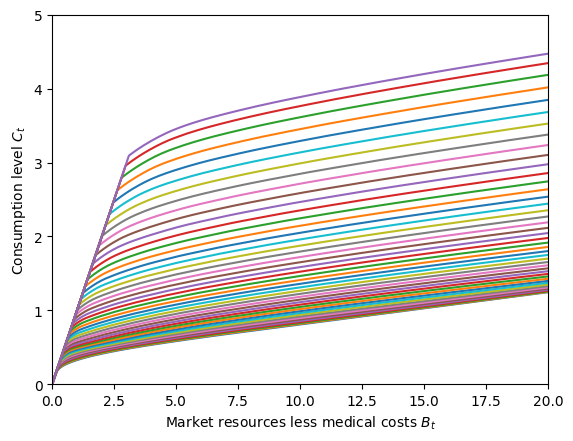

In [4]:
# Plot the consumption function by permanent income level
print("Consumption function by permanent income level:")
plt.xlim(0.0, 20.0)
plt.ylim(0.0, 5.0)
plt.xlabel(r"Market resources less medical costs $B_t$")
plt.ylabel(r"Consumption level $C_t$")
plot_funcs(MyType.solution[0].cFunc.xInterpolators, 0.0, 20.0)

Expected medical expense function by permanent income level:


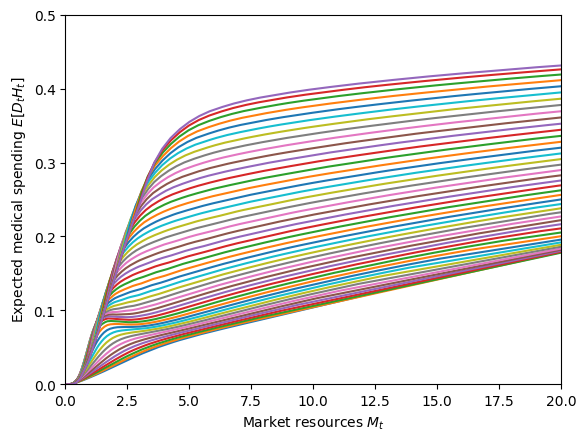

In [5]:
# Plot expected medical spending function by permanent income level
print("Expected medical expense function by permanent income level:")
plt.xlim(0.0, 20.0)
plt.ylim(0.0, 0.5)
plt.xlabel(r"Market resources $M_t$")
plt.ylabel(r"Expected medical spending $E[D_t H_t]$")
plot_funcs(MyType.solution[0].ExpMedFunc.xInterpolators, 0.0, 20.0)

Probability of medical treatment function by permanent income level:


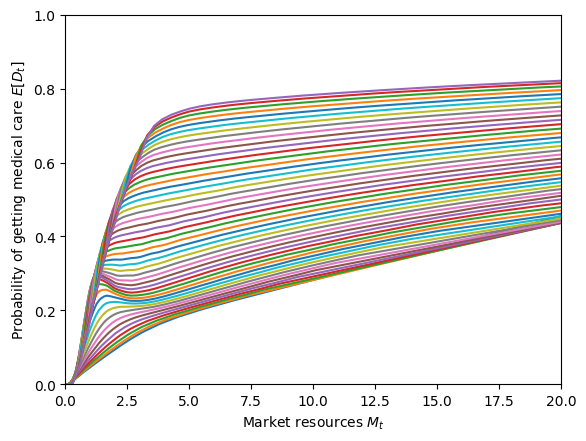

In [6]:
# Plot probability of medical treatment function by permanent income level
print("Probability of medical treatment function by permanent income level:")
plt.xlim(0.0, 20.0)
plt.ylim(0.0, 1.0)
plt.xlabel(r"Market resources $M_t$")
plt.ylabel(r"Probability of getting medical care $E[D_t]$")
plot_funcs(MyType.solution[0].CareProbFunc.xInterpolators, 0.0, 20.0)

In [7]:
# Simulate the model
MyType.track_vars = ["aLvl", "cLvl", "Med"]
MyType.T_sim = 100
t0 = time()
MyType.initialize_sim()
MyType.simulate()
t1 = time()
print("Simulating the model for 100 periods took " + mystr(t1 - t0) + " seconds.")

Simulating the model for 100 periods took 2.6497 seconds.


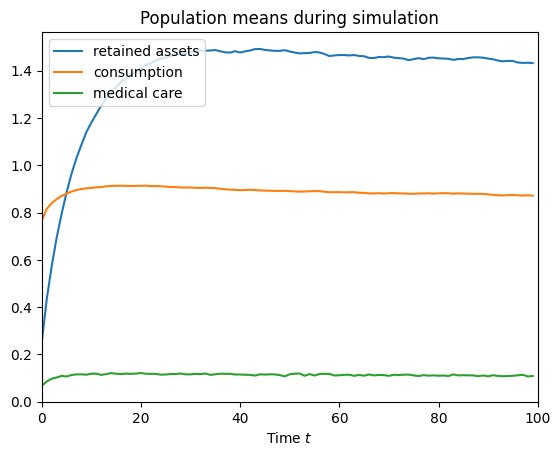

In [8]:
# Plot mean outcomes during the simulation
plt.plot(np.mean(MyType.history["aLvl"], axis=1), label="retained assets")
plt.plot(np.mean(MyType.history["cLvl"], axis=1), label="consumption")
plt.plot(np.mean(MyType.history["Med"], axis=1), label="medical care")
plt.legend()
plt.xlim(0.0, MyType.T_sim)
plt.ylim(0.0, None)
plt.title("Population means during simulation")
plt.xlabel(r"Time $t$")
plt.show()